In [105]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import deepwave
import torch.optim as optim
import itertools
import pandas as pd
from torch.utils.data import Subset

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score

from seismiclip.bert import *
from seismiclip.vit import *
from seismiclip.clip import *
from seismiclip.plots import *
from seismiclip.utils import *
from seismiclip.storseismic import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

parent_dir = "/home/randycm/Documents/Research/Projects/CLIPS/experiments"
parent_dir = os.path.join(parent_dir, "experiment_3")
if not os.path.exists(os.path.join(parent_dir)):
    os.mkdir(parent_dir)

cuda


## Inference

In [2]:
import torch.utils
import torch.utils.data
from transformers import BertConfig, BertForMaskedLM
import transformers
import time

bert_config = BertConfig()

# Model Parameter
bert_config.hidden_size = 256
bert_config.num_hidden_layers = 4
bert_config.num_attention_heads = 4
bert_config.num_hidden_ffn = 4
bert_config.attention_type = "default"
bert_config.k = 20
bert_config.fixed = False
bert_config.add_alibi = False # Add Linear Bias option (https://arxiv.org/abs/2108.12409)
bert_config.alibi_type = "nosym"
bert_config.fixed_slopes = False
bert_config.add_urpe = False # Add Universal Relative Positional Encoding (https://arxiv.org/abs/2205.13401)

bert_config.vocab_size = 1000 # Time samples
bert_config.intermediate_size = bert_config.hidden_size*bert_config.num_hidden_ffn
bert_config.max_length = 70 # Offsets
bert_config.max_position_embeddings = bert_config.max_length
bert_config.position_embedding_type = 'sincos'
bert_config.input_type = 'trace'
bert_config.embedding_type = 'none'
bert_config.type_vocab_size = 2
bert_config.output_hidden_states = True
bert_config.output_attentions = True
bert_config.output_scores = True

# Toggle Pre-LN BERT
bert_config.pre_ln = True

# Training Parameter
bert_config.batch_size = 1024//2
bert_config.lr = 5e-4
bert_config.epoch = 400
bert_config.patience = 50

# I/O parameter
bert_config.parent_dir = './temp-example-7/'
bert_config.dataset = './data/pretrain/'

# Torch Dataloader
# bert_trainloader = torch.utils.data.DataLoader(train_data, batch_size=bert_config.batch_size, shuffle=True)
# bert_testloader = torch.utils.data.DataLoader(test_data, batch_size=bert_config.batch_size, shuffle=True)

print(bert_config)

device = 'cuda'

# Changing the base transformers components according to Harsuko and Alkhalifah (2022)
transformers.models.bert.modeling_bert.BertEmbeddings = BertEmbeddings
transformers.models.bert.modeling_bert.BertOnlyMLMHead = BertOnlyMLMHead
transformers.models.bert.modeling_bert.BertSelfAttention = BertSelfAttention

if bert_config.pre_ln:
    transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput

# Configure the BERT model
bert_model = BertForMaskedLM(bert_config).to(device)

print(bert_model)

BertConfig {
  "add_alibi": false,
  "add_urpe": false,
  "alibi_type": "nosym",
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "default",
  "batch_size": 512,
  "classifier_dropout": null,
  "dataset": "./data/pretrain/",
  "embedding_type": "none",
  "epoch": 400,
  "fixed": false,
  "fixed_slopes": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "k": 20,
  "layer_norm_eps": 1e-12,
  "lr": 0.0005,
  "max_length": 70,
  "max_position_embeddings": 70,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./temp-example-7/",
  "patience": 50,
  "position_embedding_type": "sincos",
  "pre_ln": true,
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_si

# CLIP Training

In [3]:
def create_image_embeddings(images, vit_model, image_projector):
    with torch.no_grad():
        image_embeddings = vit_model(images)
        image_projection = image_projector(image_embeddings)
    return image_projection

def image_retrieval_function(inputs, n , bert_config, bert_model, text_projector, image_embeddings_list_train, clip_trainset, display=False, parent_dir=None, epoch=0):
    f, ax = plt.subplots(2, n+1, figsize=(10, 5))
    with torch.no_grad():
        
        print(inputs[0].shape, inputs[1].shape)
        
        # plt.figure()
        ax[0, 0].imshow(inputs[1][0].detach().cpu().numpy(), vmin=-1, vmax=1)
        ax[0, 0].set_xticks([])
        ax[0, 0].set_yticks([])
        # plt.show()
        
        # plt.figure()
        ax[1, 0].imshow(inputs[0].view(-1,bert_config.max_length,bert_config.vocab_size)[0].T.detach().cpu().numpy(), aspect='auto', vmin=-1, vmax=1)
        ax[1, 0].set_xticks([])
        ax[1, 0].set_yticks([])
        # plt.show()
        
        outputs = bert_model(inputs_embeds=inputs[0].view(-1,bert_config.max_length,bert_config.vocab_size).to(device))
        text_embeddings = outputs.hidden_states[-1].mean(dim=1)
        text_projection = text_projector(text_embeddings)
    
    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )
    
    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for i, index in enumerate(max_indexes):
            seismic_tensor, image_tensor = clip_trainset[index]
            ax[0, i+1].imshow(image_tensor[0].detach().cpu().numpy(), vmin=-1, vmax=1)
            ax[0, i+1].set_xticks([])
            ax[0, i+1].set_yticks([])

            ax[1, i+1].imshow(seismic_tensor.cpu().numpy().T, aspect='auto', vmin=-1, vmax=1)
            ax[1, i+1].set_xticks([])
            ax[1, i+1].set_yticks([])
        if parent_dir is not None:
            plt.savefig(os.path.join(parent_dir, 'similar_img_'+str(epoch)+'.pdf'))
        plt.show()
        return None
    else:
        return max_indexes, similarity_scores_list

In [4]:
def load_all(parent_dir):
    vit_model_dict = torch.load(os.path.join(parent_dir, 'vit_model.pt'), map_location='cpu')
    bert_model_dict = torch.load(os.path.join(parent_dir, 'bert_model.pt'), map_location='cpu')
    image_projector_dict = torch.load(os.path.join(parent_dir, 'image_projector.pt'), map_location='cpu')
    text_projector_dict = torch.load(os.path.join(parent_dir, 'text_projector.pt'), map_location='cpu')
    optimizer_state_dict =torch.load(os.path.join(parent_dir, 'optimizer.pt'), map_location='cpu')
    lr_scheduler_state_dict =torch.load(os.path.join(parent_dir, 'optimizer.pt'), map_location='cpu')
    losses = list(np.load(os.path.join(parent_dir, 'losses.npy')))

    return vit_model_dict, bert_model_dict, image_projector_dict, text_projector_dict, optimizer_state_dict, lr_scheduler_state_dict, losses

In [5]:
if os.path.exists(parent_dir):
    try:
        vit_model_dict, bert_model_dict, image_projector_dict, text_projector_dict, optimizer_state_dict, lr_scheduler_state_dict, losses = \
              load_all(parent_dir)
        print("Loaded checkpoints successfully, continuing training...")
        cont = True
    except Exception as e:
        print(e)
        cont = False
else:
    cont = False

# Hyperparameters
shared_embedding_size = 256  # d_e shared embedding space

# Create model components

# ViT Model
image_size = 64
patch_size = 16
# batch_size = 1
d_model = 256
n_heads = 4
dim_feedforward = 1024
num_layers = 4
image_embedding_size=256  # d_i
num_epochs = 100

vit_model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers)
if cont:
    vit_model.load_state_dict(vit_model_dict)
vit_model.to(device)
print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(vit_model))

# BERT Model
# Configure the BERT model
bert_model = BertForMaskedLM(bert_config)
# saved_bert = torch.load('/home/randycm/Documents/Research/Projects/CLIPS/data/988128checkpoint.pt')
# bert_model.load_state_dict(saved_bert.state_dict())
if cont:
    bert_model.load_state_dict(bert_model_dict)
bert_model.to(device)
max_length = bert_config.max_length
text_embedding_size = bert_config.hidden_size  # d_i

# Load pre-trained DistilBERT model and tokenizer
print(" Number of Trainable Parameters in", " BERT model :  ",  count_trainable_parameters(bert_model))

# Projections  
image_projector = ImageProjection(image_embedding_size, shared_embedding_size)
if cont:
    image_projector.load_state_dict(image_projector_dict)
image_projector.to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size)
if cont:
    text_projector.load_state_dict(text_projector_dict)
text_projector.to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))

# Loss  
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# Optimizer  
params = [
    {"params":vit_model.parameters(), "lr":1e-3 }, {"params":bert_model.parameters(), "lr":1e-4}, 
    {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() ), "lr":1e-3 , "weight_decay":1e-3 }
]
optimizer = torch.optim.AdamW( params,  weight_decay=0.0 )
if cont:
    optimizer.load_state_dict(optimizer_state_dict)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=1 , factor=0.8 )
if cont:
    lr_scheduler.load_state_dict(lr_scheduler_state_dict)

# CLIP dataloader
# Initialize dataset with all data
data_dirs = ['/home/randycm/Documents/Research/Transformers/data/E-FWI/FVA/', 
             '/home/randycm/Documents/Research/Transformers/data/E-FWI/FVB/']
shot_indices = [2]

# Create dataset instance without specifying shot_indices to use all shots
dataset = SeismicVelocityDataset2(data_dirs=data_dirs, shot_indices=shot_indices, device='cuda', transform="log1p", alpha=50, return_real_vel=True)

# Get indices for the training-testing split
shuffle = True
total_len = len(dataset)

if shuffle:
    idxs = torch.randperm(total_len)
else:
    idxs = torch.arange(total_len)

train_prop = 0.8
train_len = int(np.ceil(train_prop * total_len))
print("Training data length: ", train_len)
print("Testing data length: ", total_len - train_len)

# Split indices into training and testing
train_idxs = idxs[:train_len]
test_idxs = idxs[train_len:]

# Create subsets for training and testing
clip_trainset = Subset(dataset, train_idxs)
clip_testset = Subset(dataset, test_idxs)

batch_size = 32
clip_trainloader = DataLoader(clip_trainset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4)
    # torch.from_numpy(vels[:90]).repeat_interleave(np.array(seismic_data).shape[1], 0)), batch_size=2, shuffle=True)
clip_testloader = DataLoader(clip_testset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4)
    # torch.from_numpy(vels[90:]).repeat_interleave(np.array(seismic_data).shape[1], 0)), batch_size=2, shuffle=True)
clip_evalloader = DataLoader(clip_trainset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4)

Loaded checkpoints successfully, continuing training...
 Number of Trainable Parameters in  ViT model :   3421952
 Number of Trainable Parameters in  BERT model :   3672808
 Number of Trainable Parameters in  Image Projection :   132096
 Number of Trainable Parameters in  Text Projection :   132096
Training data length:  48000
Testing data length:  12000


# Evaluate & Visualize

In [6]:
def get_features(dataloader):
    all_features1 = []
    all_features2 = []
    all_velocities = []
    all_velocities_real = []
    all_labels = []
    
    with torch.no_grad():
        for (seismic, velocity, labels, velocity_real) in tqdm(dataloader):
            seismic = seismic.to(device)
            features1 = bert_model(inputs_embeds=seismic)
            features1 = features1.hidden_states[-1].mean(dim=1)

            velocity = velocity.to(device)
            features2 = vit_model(velocity)

            all_features1.append(features1.cpu())
            all_features2.append(features2.cpu())
            all_velocities.append(velocity.cpu())
            all_velocities_real.append(velocity_real.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_features1).cpu().numpy(), torch.cat(all_features2).cpu().numpy(), \
        torch.cat(all_velocities).cpu().numpy(), torch.cat(all_labels).cpu().numpy(), torch.cat(all_velocities_real).cpu().numpy()

vit_model.eval()
bert_model.eval()
image_projector.eval()
text_projector.eval()

# Calculate train features
train_features1, train_features2, train_velocities, train_labels, train_velocities_real = get_features(clip_evalloader)

# Calculate test features
test_features1, test_features2, test_velocities, test_labels, test_velocities_real = get_features(clip_testloader)

100%|████████████████████████████████████████████| 375/375 [00:08<00:00, 45.50it/s]


## TSNE

In [7]:
X_embedded_train1 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25, verbose=True).fit_transform(train_features1)
X_embedded_train2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25, verbose=True).fit_transform(train_features2)
X_embedded_test1 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25, verbose=True).fit_transform(test_features1)
X_embedded_test2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25, verbose=True).fit_transform(test_features2)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 48000 samples in 0.008s...
[t-SNE] Computed neighbors for 48000 samples in 7.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48000
[t-SNE] Computed conditional probabilities for sample 2000 / 48000
[t-SNE] Computed conditional probabilities for sample 3000 / 48000
[t-SNE] Computed conditional probabilities for sample 4000 / 48000
[t-SNE] Computed conditional probabilities for sample 5000 / 48000
[t-SNE] Computed conditional probabilities for sample 6000 / 48000
[t-SNE] Computed conditional probabilities for sample 7000 / 48000
[t-SNE] Computed conditional probabilities for sample 8000 / 48000
[t-SNE] Computed conditional probabilities for sample 9000 / 48000
[t-SNE] Computed conditional probabilities for sample 10000 / 48000
[t-SNE] Computed conditional probabilities for sample 11000 / 48000
[t-SNE] Computed conditional probabilities for sample 12000 / 48000
[t-SNE] Computed conditional probabilities for sam

In [181]:
np.save(os.path.join(parent_dir, 'X_embedded_train1.npy'), X_embedded_train1)
np.save(os.path.join(parent_dir, 'X_embedded_train2.npy'), X_embedded_train2)
np.save(os.path.join(parent_dir, 'X_embedded_test1.npy'), X_embedded_test1)
np.save(os.path.join(parent_dir, 'X_embedded_test2.npy'), X_embedded_test2)

### Separating velocity class

#### From seismic

##### Training

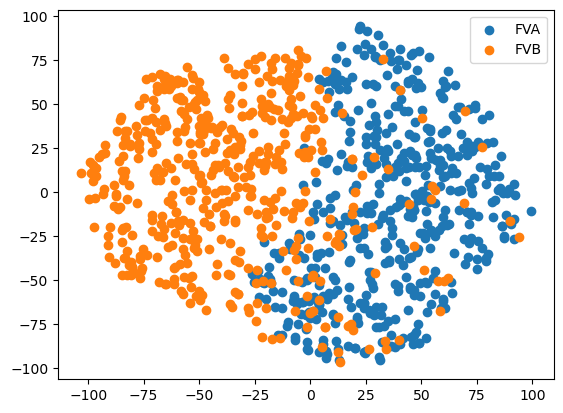

In [8]:
idx = np.random.permutation(len(X_embedded_train1))[:1000]
plt.scatter(X_embedded_train1[idx][train_labels[idx] == 0, 0], X_embedded_train1[idx][train_labels[idx] == 0, 1], label="FVA")
plt.scatter(X_embedded_train1[idx][train_labels[idx] == 1, 0], X_embedded_train1[idx][train_labels[idx] == 1, 1], label="FVB")
plt.legend()

##### Testing

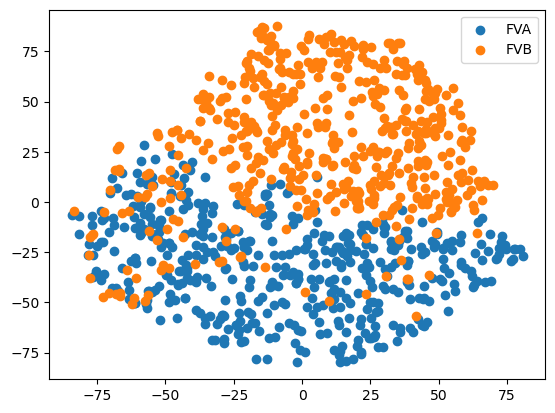

In [9]:
idx = np.random.permutation(len(X_embedded_test1))[:1000]
plt.scatter(X_embedded_test1[idx][test_labels[idx] == 0, 0], X_embedded_test1[idx][test_labels[idx] == 0, 1], label="FVA")
plt.scatter(X_embedded_test1[idx][test_labels[idx] == 1, 0], X_embedded_test1[idx][test_labels[idx] == 1, 1], label="FVB")
plt.legend()

#### From velocity

##### Training

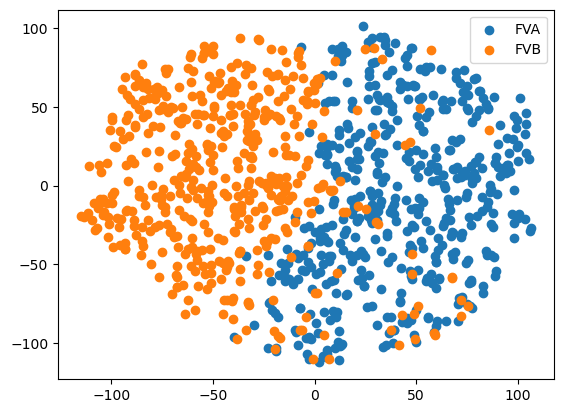

In [10]:
idx = np.random.permutation(len(X_embedded_train2))[:1000]
plt.scatter(X_embedded_train2[idx][train_labels[idx] == 0, 0], X_embedded_train2[idx][train_labels[idx] == 0, 1], label="FVA")
plt.scatter(X_embedded_train2[idx][train_labels[idx] == 1, 0], X_embedded_train2[idx][train_labels[idx] == 1, 1], label="FVB")
plt.legend()

##### Testing

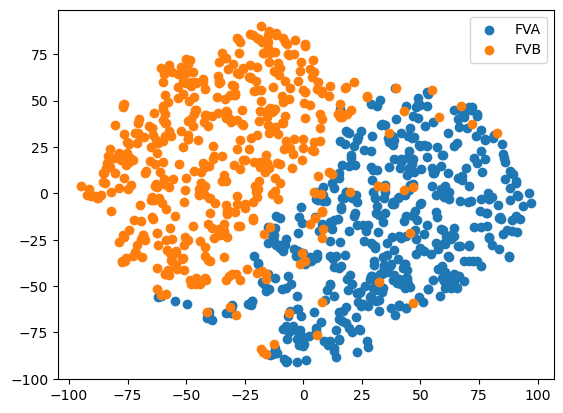

In [11]:
idx = np.random.permutation(len(X_embedded_test2))[:1000]
plt.scatter(X_embedded_test2[idx][test_labels[idx] == 0, 0], X_embedded_test2[idx][test_labels[idx] == 0, 1], label="FVA")
plt.scatter(X_embedded_test2[idx][test_labels[idx] == 1, 0], X_embedded_test2[idx][test_labels[idx] == 1, 1], label="FVB")
plt.legend()

### Separating land/marine

(array([  4224.,  10880.,  17024.,  21120.,  27328.,  33600.,  37568.,
         43584.,  50880.,  54336.,  63040.,  61056.,  72128.,  80832.,
         81600.,  94272., 100800.,  94784.,  86144.,  75840.,  75904.,
         73600.,  67712.,  66432.,  62400.,  59328.,  54272.,  52608.,
         52544.,  47744.,  47360.,  47296.,  43712.,  41856.,  39104.,
         36864.,  33664.,  36224.,  34880.,  29248.,  30848.,  29568.,
         30336.,  27968.,  27072.,  28096.,  30208.,  25344.,  25088.,
         25920.,  23488.,  25216.,  24192.,  23168.,  23936.,  21760.,
         24064.,  20672.,  20736.,  19328.,  18880.,  19136.,  20864.,
         19200.,  19264.,  16064.,  16064.,  16128.,  15680.,  18112.,
         13632.,  16576.,  19008.,  14848.,  13504.,  14080.,  14656.,
         13440.,  10624.,  12672.,   9216.,  10304.,  10816.,  11072.,
          8640.,   8256.,   8512.,   8128.,   7424.,   7680.,   7232.,
          5952.,   5376.,   4352.,   4672.,   3328.,   2752.,   2432.,
      

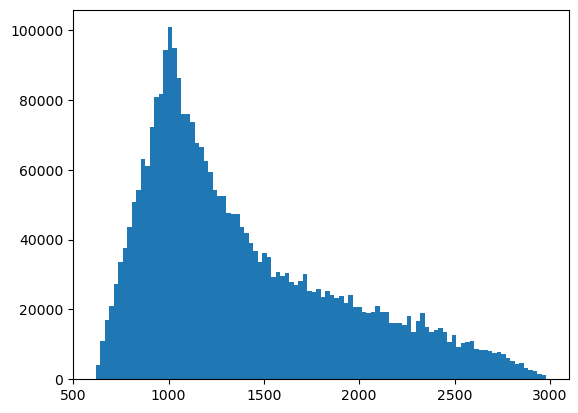

In [25]:
plt.hist(train_velocities_real[:, 1, 0, :].flatten(), bins=100)

(array([105984., 100288.,  95232.,  94592.,  90368.,  82496.,  78016.,
         75200.,  71936.,  71424.,  68224.,  66240.,  62848.,  60864.,
         57024.,  54272.,  49024.,  49856.,  45312.,  46336.,  42944.,
         42560.,  40576.,  39872.,  36480.,  33280.,  36672.,  35136.,
         30656.,  31552.,  32576.,  28928.,  29696.,  28544.,  26304.,
         24192.,  25344.,  25536.,  23040.,  21312.,  22400.,  20928.,
         20544.,  19968.,  20416.,  19712.,  20160.,  20480.,  18176.,
         19968.,  18432.,  17536.,  20288.,  18496.,  20352.,  17152.,
         17728.,  18240.,  15680.,  16448.,  15296.,  17024.,  15488.,
         15424.,  16768.,  16448.,  15616.,  14720.,  16768.,  15616.,
         17728.,  15040.,  15616.,  15616.,  17024.,  14400.,  14720.,
         15680.,  15808.,  16512.,  16960.,  15104.,  14592.,  14912.,
         15424.,  15168.,  15872.,  15872.,  15744.,  16256.,  14528.,
         13952.,  16640.,  15168.,  14208.,  15360.,  15936.,  13568.,
      

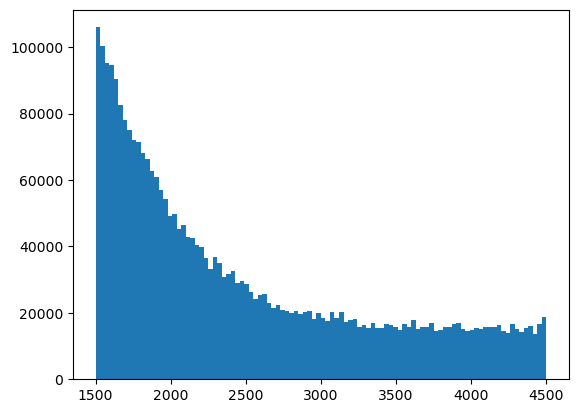

In [60]:
plt.hist(train_velocities_real[:, 0, 0, :].flatten(), bins=100)

In [63]:
vel_treshold = 750

#### From seismic

##### Training

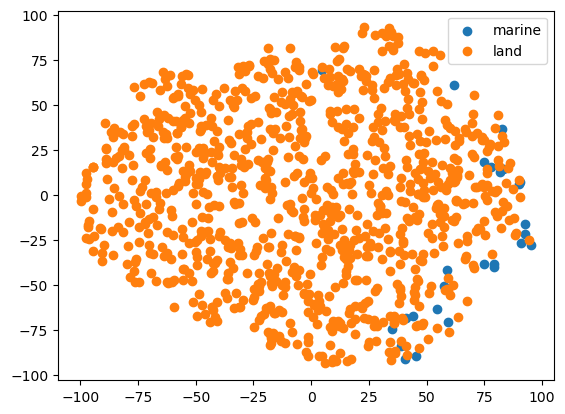

In [64]:
idx = np.random.permutation(len(X_embedded_train1))[:1000]
plt.scatter(X_embedded_train1[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 0], 
            X_embedded_train1[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 1], label="marine")
plt.scatter(X_embedded_train1[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 0], 
            X_embedded_train1[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 1], label="land")
plt.legend()

##### Testing

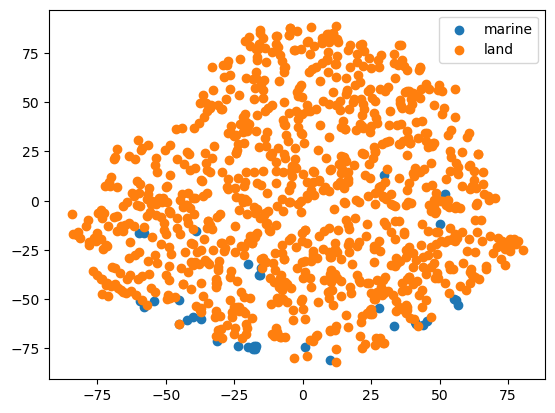

In [65]:
idx = np.random.permutation(len(X_embedded_test1))[:1000]
plt.scatter(X_embedded_test1[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 0], 
            X_embedded_test1[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 1], label="marine")
plt.scatter(X_embedded_test1[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 0], 
            X_embedded_test1[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 1], label="land")
plt.legend()

#### From velocity

##### Training

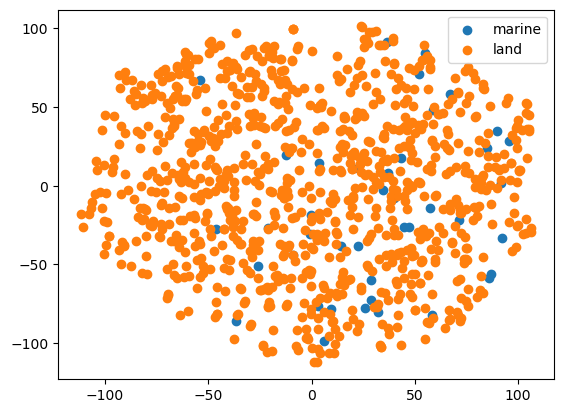

In [66]:
idx = np.random.permutation(len(X_embedded_train2))[:1000]
plt.scatter(X_embedded_train2[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 0], 
            X_embedded_train2[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 1], label="marine")
plt.scatter(X_embedded_train2[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 0], 
            X_embedded_train2[idx][train_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 1], label="land")
plt.legend()

##### Testing

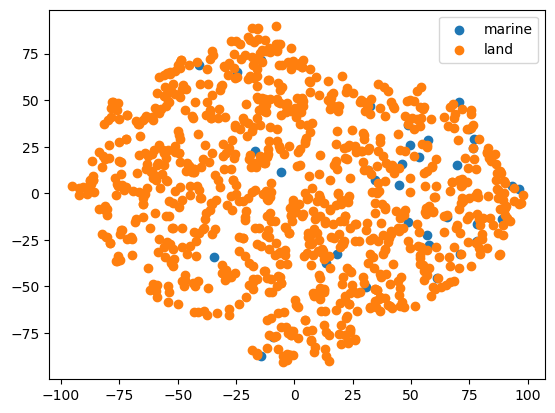

In [67]:
idx = np.random.permutation(len(X_embedded_test2))[:1000]
plt.scatter(X_embedded_test2[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 0], 
            X_embedded_test2[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) <= vel_treshold, 1], label="marine")
plt.scatter(X_embedded_test2[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 0], 
            X_embedded_test2[idx][test_velocities_real[idx][:, 1, 0, :].mean(axis=-1) > vel_treshold, 1], label="land")
plt.legend()

### Clustering number of layers

In [90]:
train_vel_n_layers = np.count_nonzero(np.diff(train_velocities_real[:, 0, :, 0], axis=-1), axis=-1) + 1
test_vel_n_layers = np.count_nonzero(np.diff(test_velocities_real[:, 0, :, 0], axis=-1), axis=-1) + 1

#### From seismic

##### Training

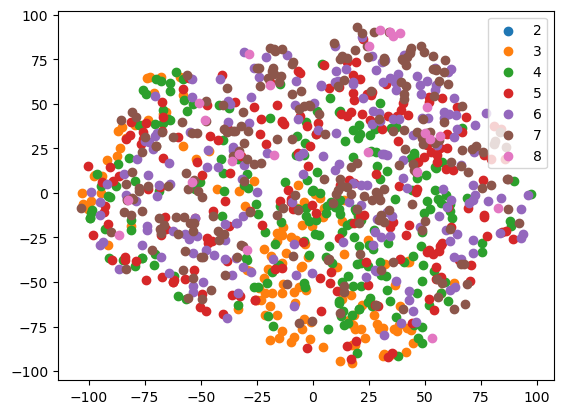

In [95]:
idx = np.random.permutation(len(X_embedded_train1))[:1000]
for i, nl in enumerate(np.unique(train_vel_n_layers)):
    plt.scatter(X_embedded_train1[idx][train_vel_n_layers[idx] == nl, 0], 
                X_embedded_train1[idx][train_vel_n_layers[idx] == nl, 1], label=str(nl))
plt.legend()

##### Testing

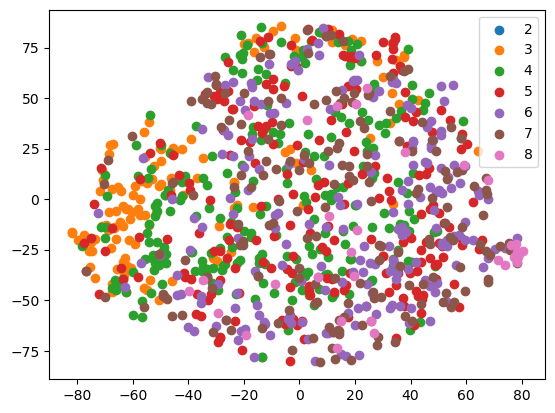

In [98]:
idx = np.random.permutation(len(X_embedded_test1))[:1000]
for i, nl in enumerate(np.unique(test_vel_n_layers)):
    plt.scatter(X_embedded_test1[idx][test_vel_n_layers[idx] == nl, 0], 
                X_embedded_test1[idx][test_vel_n_layers[idx] == nl, 1], label=str(nl))
plt.legend()

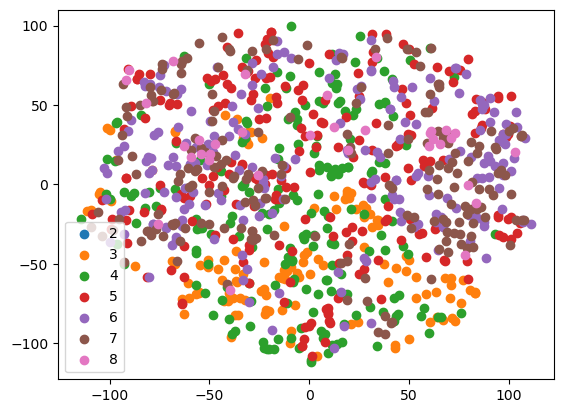

In [96]:
idx = np.random.permutation(len(X_embedded_train2))[:1000]
for i, nl in enumerate(np.unique(train_vel_n_layers)):
    plt.scatter(X_embedded_train2[idx][train_vel_n_layers[idx] == nl, 0], 
                X_embedded_train2[idx][train_vel_n_layers[idx] == nl, 1], label=str(nl))
plt.legend()

#### From velocity

##### Training

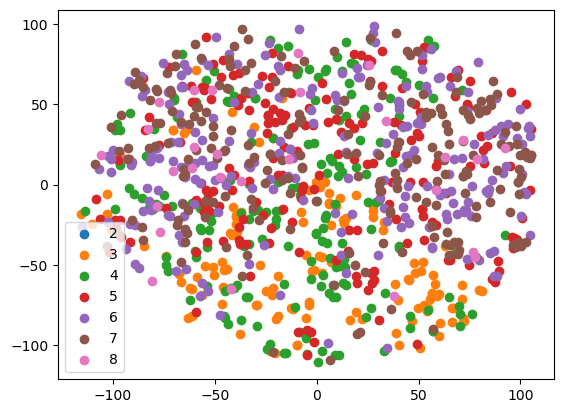

In [99]:
idx = np.random.permutation(len(X_embedded_train2))[:1000]
for i, nl in enumerate(np.unique(train_vel_n_layers)):
    plt.scatter(X_embedded_train2[idx][train_vel_n_layers[idx] == nl, 0], 
                X_embedded_train2[idx][train_vel_n_layers[idx] == nl, 1], label=str(nl))
plt.legend()

##### Testing

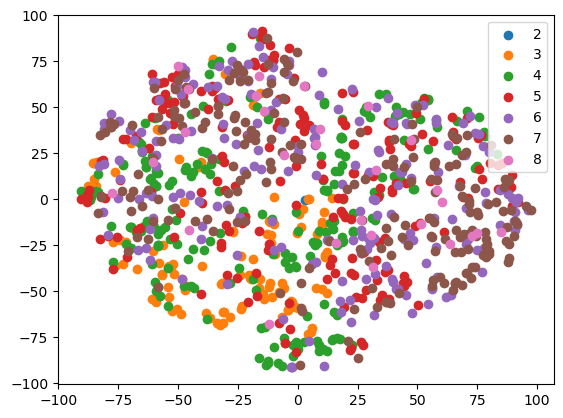

In [100]:
idx = np.random.permutation(len(X_embedded_test2))[:1000]
for i, nl in enumerate(np.unique(test_vel_n_layers)):
    plt.scatter(X_embedded_test2[idx][test_vel_n_layers[idx] == nl, 0], 
                X_embedded_test2[idx][test_vel_n_layers[idx] == nl, 1], label=str(nl))
plt.legend()

## Linear Probing

In [142]:
def get_metrics(true, pred, return_f1=True):
    conf_mat = confusion_matrix(true, pred)
    accuracy = np.mean((true == pred).astype(float)) * 100.

    if return_f1:
        f1 = f1_score(true, pred)
        
        return accuracy, f1, conf_mat
    
    return accuracy, conf_mat

### Classifying velocity class

#### From seismic

In [102]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features1, train_labels)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          257     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  3.32228D-01


 This problem is unconstrained.



At iterate   50    f=  1.42643D-01    |proj g|=  4.83313D-04

At iterate  100    f=  1.42239D-01    |proj g|=  2.20330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  257    102    110      1     0     0   9.170D-05   1.422D-01
  F =  0.14223591133366825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [106]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(train_features1)
accuracy = np.mean((train_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(train_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 94.837
F1 Score = 0.947
Confusion matrix [[23199   836]
 [ 1642 22323]]


In [108]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features1)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(test_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 94.633
F1 Score = 0.946
Confusion matrix [[5751  214]
 [ 430 5605]]


#### From velocity

In [109]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features2, train_labels)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          257     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.79455D+01


 This problem is unconstrained.



At iterate   50    f=  1.47786D-01    |proj g|=  1.51373D-01

At iterate  100    f=  1.42695D-01    |proj g|=  8.19822D-02

At iterate  150    f=  1.38911D-01    |proj g|=  5.94079D-02

At iterate  200    f=  1.37553D-01    |proj g|=  4.16465D-02

At iterate  250    f=  1.35992D-01    |proj g|=  5.48866D-02

At iterate  300    f=  1.34401D-01    |proj g|=  2.64967D-02

At iterate  350    f=  1.33505D-01    |proj g|=  1.43490D-02

At iterate  400    f=  1.32645D-01    |proj g|=  2.13122D-02

At iterate  450    f=  1.32138D-01    |proj g|=  1.87091D-02

At iterate  500    f=  1.30980D-01    |proj g|=  6.96799D-02

At iterate  550    f=  1.30548D-01    |proj g|=  5.86841D-02

At iterate  600    f=  1.29946D-01    |proj g|=  1.74179D-02

At iterate  650    f=  1.29454D-01    |proj g|=  2.33849D-02

At iterate  700    f=  1.28989D-01    |proj g|=  3.16185D-02

At iterate  750    f=  1.28470D-01    |proj g|=  1.54834D-02

At iterate  800    f=  1.28318D-01    |proj g|=  1.53326D-02

At iter

LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [110]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(train_features2)
accuracy = np.mean((train_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(train_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 95.417
F1 Score = 0.953
Confusion matrix [[23592   443]
 [ 1757 22208]]


In [111]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features2)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(test_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 95.208
F1 Score = 0.951
Confusion matrix [[5852  113]
 [ 462 5573]]


#### From random

In [115]:
# Perform logistic regression
rand_feat1 = np.random.rand(*train_features2.shape)
rand_feat2 = np.random.rand(*test_features2.shape)
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(rand_feat1, train_labels)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          257     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.30550D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  257     10     14      1     0     0   2.992D-05   6.900D-01
  F =  0.69003022852515516     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [116]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(rand_feat1)
accuracy = np.mean((train_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(train_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 53.000
F1 Score = 0.526
Confusion matrix [[12923 11112]
 [11448 12517]]


In [117]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(rand_feat2)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(test_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 49.858
F1 Score = 0.492
Confusion matrix [[3064 2901]
 [3116 2919]]


### Classifying land/marine

In [159]:
vel_treshold = 750

train_landmarine_labels = np.zeros(train_velocities_real.shape[0])
train_landmarine_labels[train_velocities_real[:, 1, 0, :].mean(axis=-1) > vel_treshold] = 1

test_landmarine_labels = np.zeros(test_velocities_real.shape[0])
test_landmarine_labels[test_velocities_real[:, 1, 0, :].mean(axis=-1) > vel_treshold] = 1

#### From seismic

In [160]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features1, train_landmarine_labels)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          257     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.67021D-01


 This problem is unconstrained.



At iterate   50    f=  2.15929D-02    |proj g|=  3.47541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  257     60     66      1     0     0   9.411D-05   2.146D-02
  F =   2.1460534149049224E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [161]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(train_features1)
accuracy = np.mean((train_landmarine_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(train_landmarine_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 99.240
F1 Score = 0.996
Confusion matrix [[ 1347   236]
 [  129 46288]]


In [162]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features1)
accuracy = np.mean((test_landmarine_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(test_landmarine_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 99.117
F1 Score = 0.995
Confusion matrix [[  325    68]
 [   38 11569]]


#### From velocity

In [163]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features2, train_landmarine_labels)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          257     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  3.86823D+01


 This problem is unconstrained.



At iterate   50    f=  1.39151D-01    |proj g|=  5.16443D-02

At iterate  100    f=  1.35488D-01    |proj g|=  5.18656D-02

At iterate  150    f=  1.34317D-01    |proj g|=  4.80361D-02

At iterate  200    f=  1.33830D-01    |proj g|=  1.03911D-02

At iterate  250    f=  1.33422D-01    |proj g|=  1.39489D-02

At iterate  300    f=  1.33095D-01    |proj g|=  2.66572D-02

At iterate  350    f=  1.32816D-01    |proj g|=  3.25875D-02

At iterate  400    f=  1.32491D-01    |proj g|=  1.10224D-02

At iterate  450    f=  1.32429D-01    |proj g|=  1.14931D-02

At iterate  500    f=  1.32309D-01    |proj g|=  4.49240D-03

At iterate  550    f=  1.32177D-01    |proj g|=  5.73854D-03

At iterate  600    f=  1.32122D-01    |proj g|=  1.09262D-02

At iterate  650    f=  1.32043D-01    |proj g|=  4.69593D-03

At iterate  700    f=  1.31999D-01    |proj g|=  3.65402D-03

At iterate  750    f=  1.31956D-01    |proj g|=  3.88071D-03

At iterate  800    f=  1.31928D-01    |proj g|=  8.35155D-03

At iter

LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [164]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(train_features2)
accuracy = np.mean((train_landmarine_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(train_landmarine_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 96.702
F1 Score = 0.983
Confusion matrix [[    0  1583]
 [    0 46417]]


In [165]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features2)
accuracy = np.mean((test_landmarine_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(test_landmarine_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 96.725
F1 Score = 0.983
Confusion matrix [[    0   393]
 [    0 11607]]


#### From random

In [169]:
# Perform logistic regression
rand_feat1 = np.random.rand(*train_features2.shape)
rand_feat2 = np.random.rand(*test_features2.shape)
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(rand_feat1, train_landmarine_labels)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          257     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.67021D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  257     38     45      1     0     0   7.131D-05   1.422D-01
  F =  0.14221353388334748     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [170]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(rand_feat1)
accuracy = np.mean((train_landmarine_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(train_landmarine_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 96.702
F1 Score = 0.983
Confusion matrix [[    0  1583]
 [    0 46417]]


In [171]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(rand_feat2)
accuracy = np.mean((test_landmarine_labels == predictions).astype(float)) * 100.
accuracy, f1, conf_mat = get_metrics(test_landmarine_labels, predictions)
print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score = {f1:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 96.725
F1 Score = 0.983
Confusion matrix [[    0   393]
 [    0 11607]]


### Classifying number of layers

#### From seismic

In [137]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features1, train_vel_n_layers)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1799     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  1.42732D-01


 This problem is unconstrained.



At iterate   50    f=  1.20302D+00    |proj g|=  5.15819D-03

At iterate  100    f=  1.19210D+00    |proj g|=  2.27367D-03

At iterate  150    f=  1.18969D+00    |proj g|=  1.54860D-03

At iterate  200    f=  1.18889D+00    |proj g|=  3.35576D-04

At iterate  250    f=  1.18859D+00    |proj g|=  2.30803D-04

At iterate  300    f=  1.18841D+00    |proj g|=  6.79116D-04

At iterate  350    f=  1.18831D+00    |proj g|=  1.54108D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1799    384    424      1     0     0   9.572D-05   1.188D+00
  F =   1.1882714846211699     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [148]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(train_features1)
accuracy = np.mean((train_vel_n_layers == predictions).astype(float)) * 100.
accuracy, conf_mat = get_metrics(train_vel_n_layers, predictions, return_f1=False)
print(f"Accuracy = {accuracy:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 50.040
Confusion matrix [[   0    6    0    0    0    0    0]
 [   0 4415 1405  297  124   62    0]
 [   0 1343 6143 1607  581  401    1]
 [   0  619 2250 4317 1875 1185    5]
 [   0  287 1386 2097 3741 2818   15]
 [   0  126  744 1265 2227 5321   79]
 [   0   10   94   90  185  797   82]]


In [150]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features1)
accuracy = np.mean((test_vel_n_layers == predictions).astype(float)) * 100.
accuracy, conf_mat = get_metrics(test_vel_n_layers, predictions, return_f1=False)
print(f"Accuracy = {accuracy:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 48.775
Confusion matrix [[   0    1    0    0    0    0    0]
 [   0 1105  369   86   40   16    0]
 [   0  334 1522  424  145   91    0]
 [   0  156  571 1003  492  310    1]
 [   0   86  324  530  876  669    1]
 [   0   32  184  360  566 1333   29]
 [   0    1   27   32   60  210   14]]


#### From velocity

In [157]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features2, train_vel_n_layers)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1799     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  1.16430D+01


 This problem is unconstrained.



At iterate   50    f=  1.46816D+00    |proj g|=  3.46853D-01

At iterate  100    f=  1.44081D+00    |proj g|=  1.83798D-01

At iterate  150    f=  1.42332D+00    |proj g|=  4.11693D-01

At iterate  200    f=  1.40820D+00    |proj g|=  2.58838D-01

At iterate  250    f=  1.39601D+00    |proj g|=  3.85827D-01

At iterate  300    f=  1.38606D+00    |proj g|=  1.66906D-01

At iterate  350    f=  1.37597D+00    |proj g|=  1.36558D-01

At iterate  400    f=  1.36758D+00    |proj g|=  4.14452D-01

At iterate  450    f=  1.35922D+00    |proj g|=  1.17437D-01

At iterate  500    f=  1.35026D+00    |proj g|=  2.95261D-01

At iterate  550    f=  1.34635D+00    |proj g|=  1.68415D-01

At iterate  600    f=  1.34163D+00    |proj g|=  1.28647D-01

At iterate  650    f=  1.33376D+00    |proj g|=  1.04260D-01

At iterate  700    f=  1.32890D+00    |proj g|=  1.10125D-01

At iterate  750    f=  1.32270D+00    |proj g|=  1.65490D-01

At iterate  800    f=  1.31698D+00    |proj g|=  1.14514D-01

At iter

LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [158]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(train_features2)
accuracy = np.mean((train_vel_n_layers == predictions).astype(float)) * 100.
accuracy, conf_mat = get_metrics(train_vel_n_layers, predictions, return_f1=False)
print(f"Accuracy = {accuracy:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 46.333
Confusion matrix [[   0    6    0    0    0    0    0]
 [   0 3884 1659  271  391   98    0]
 [   0 1501 5719 1730  770  354    2]
 [   0  815 1756 5131 1306 1238    5]
 [   0  542 1728 2311 3226 2525   12]
 [   1  356  985 1905 2212 4272   31]
 [   0   36  112  147  260  695    8]]


In [152]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features2)
accuracy = np.mean((test_vel_n_layers == predictions).astype(float)) * 100.
accuracy, conf_mat = get_metrics(test_vel_n_layers, predictions, return_f1=False)
print(f"Accuracy = {accuracy:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 45.292
Confusion matrix [[   0    1    0    0    0    0    0]
 [   0  951  441   96  105   23    0]
 [   0  335 1445  439  203   92    2]
 [   0  216  426 1242  351  294    4]
 [   0  127  376  591  758  627    7]
 [   0   95  268  529  572 1033    7]
 [   0    5   35   36   73  189    6]]


#### From random

In [153]:
# Perform logistic regression
rand_feat1 = np.random.rand(*train_features2.shape)
rand_feat2 = np.random.rand(*test_features2.shape)
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(rand_feat1, train_vel_n_layers)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1799     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  1.42732D-01


 This problem is unconstrained.



At iterate   50    f=  1.66182D+00    |proj g|=  2.89177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1799     67     76      1     0     0   9.745D-05   1.662D+00
  F =   1.6617713783384196     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [155]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(rand_feat1)
accuracy = np.mean((train_vel_n_layers == predictions).astype(float)) * 100.
accuracy, conf_mat = get_metrics(train_vel_n_layers, predictions, return_f1=False)
print(f"Accuracy = {accuracy:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 24.796
Confusion matrix [[   0    0    1    2    3    0    0]
 [   0   24 1549 1744 1731 1255    0]
 [   0   14 2924 2664 2676 1798    0]
 [   0   24 2374 3354 2618 1881    0]
 [   0   22 2441 2671 3345 1865    0]
 [   0   15 2263 2590 2639 2255    0]
 [   0    2  302  366  359  229    0]]


In [156]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(rand_feat2)
accuracy = np.mean((test_vel_n_layers == predictions).astype(float)) * 100.
accuracy, conf_mat = get_metrics(test_vel_n_layers, predictions, return_f1=False)
print(f"Accuracy = {accuracy:.3f}")
print("Confusion matrix", conf_mat)

Accuracy = 20.642
Confusion matrix [[  0   0   0   0   1   0   0]
 [  0   5 418 437 467 289   0]
 [  0   7 593 725 687 504   0]
 [  0   4 604 703 776 446   0]
 [  0   7 618 696 691 474   0]
 [  0   5 656 691 667 485   0]
 [  0   1  73  81 124  65   0]]


### Predicting velocity

##### From seismic (Vp)

In [182]:
regressor = nn.Linear(bert_config.hidden_size, image_size)
regressor.to(device)

reg_loss = []

optimizer_reg = torch.optim.SGD(regressor.parameters(), lr=1e-3)

loss_reg = nn.MSELoss()
reg_losses = []

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    total_loss = 0.
    for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
        # Forward pass  
        optimizer_reg.zero_grad()
        
        seismic = seismic.to(device)
        velocity = velocity.to(device)

        with torch.no_grad():
            features = bert_model(inputs_embeds=seismic)
            features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)

        loss = loss_reg(out, velocity[:, 0, :, image_size//2])

        loss.backward()
        optimizer_reg.step()

        total_loss += loss.item()

    reg_loss.append(total_loss / len(clip_evalloader))

1500it [00:24, 61.28it/s]                                   | 0/10 [00:00<?, ?it/s]
1500it [00:24, 61.95it/s]                           | 1/10 [00:24<03:44, 24.99s/it]
1500it [00:23, 64.69it/s]                           | 2/10 [00:49<03:18, 24.81s/it]
1500it [00:22, 65.83it/s]                           | 3/10 [01:13<02:50, 24.31s/it]
1500it [00:24, 61.48it/s]                           | 4/10 [01:36<02:23, 23.90s/it]
1500it [00:22, 66.07it/s]███▌                       | 5/10 [02:01<02:01, 24.26s/it]
1500it [00:22, 65.44it/s]████████▏                  | 6/10 [02:24<01:35, 23.89s/it]
1500it [00:22, 65.76it/s]████████████▉              | 7/10 [02:48<01:11, 23.73s/it]
1500it [00:22, 65.53it/s]█████████████████▌         | 8/10 [03:11<00:47, 23.59s/it]
1500it [00:22, 65.97it/s]██████████████████████▎    | 9/10 [03:34<00:23, 23.51s/it]
100%|██████████████████████████████████████████████| 10/10 [03:58<00:00, 23.80s/it]


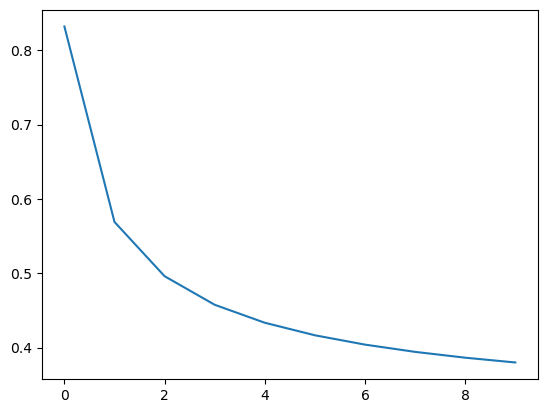

In [183]:
plt.plot(reg_loss)

In [238]:
total_loss = 0.
for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)

        loss = torch.sqrt(loss_reg(out * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

    total_loss += loss.item()

train_rmse = total_loss / len(clip_evalloader)
print("RMSE: ", train_rmse)

1500it [00:23, 63.25it/s]

RMSE:  442.5869366455078


In [235]:
total_loss = 0.
for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_testloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)

        loss = torch.sqrt(loss_reg(out * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

    total_loss += loss.item()

test_rmse = total_loss / len(clip_testloader)
print("RMSE: ", test_rmse)

375it [00:05, 62.73it/s]

RMSE:  442.7088054199219


tensor([10746, 15852, 15830, 35438, 44028])


Text(0, 0.5, 'Vp')

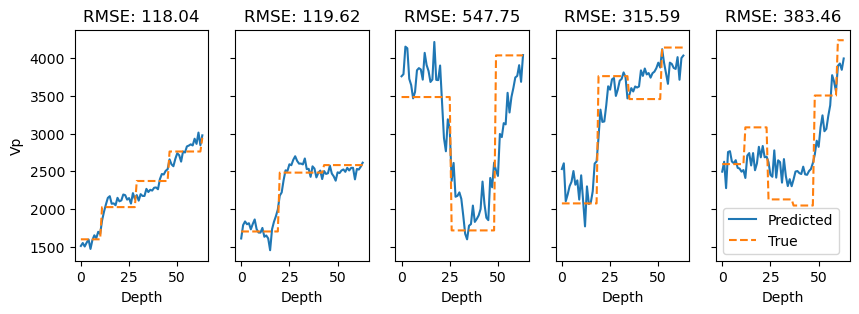

In [237]:
idx = torch.randperm(len(clip_trainset))[:5]
print(idx)

f, ax = plt.subplots(1, 5, sharey=True, figsize=(10, 3))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_trainset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out * velocity_real[0].std() + velocity_real[0].mean()

        loss = torch.sqrt(loss_reg(out, 
                                   velocity_real[0, :, image_size//2]))

    ax[i].plot(out.cpu()[0], label="Predicted")
    ax[i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[i].set_xlabel("Depth")
    ax[i].set_title("RMSE: {:.2f}".format(loss.item()))

plt.legend()
ax[0].set_ylabel("Vp")

tensor([9987, 4227, 7439, 2445, 9266])


Text(0, 0.5, 'Vp')

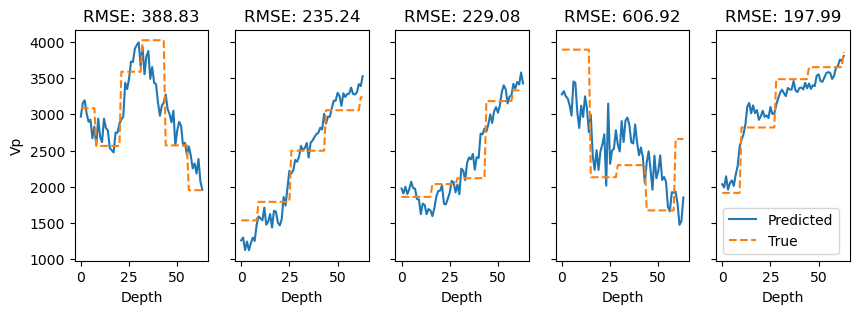

In [242]:
idx = torch.randperm(len(clip_testset))[:5]
print(idx)

f, ax = plt.subplots(1, 5, sharey=True, figsize=(10, 3))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_testset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out * velocity_real[0].std() + velocity_real[0].mean()

        loss = torch.sqrt(loss_reg(out, 
                                   velocity_real[0, :, image_size//2]))

    ax[i].plot(out.cpu()[0], label="Predicted")
    ax[i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[i].set_xlabel("Depth")
    ax[i].set_title("RMSE: {:.2f}".format(loss.item()))

plt.legend()
ax[0].set_ylabel("Vp")

##### From seismic (Multiparameter)

In [243]:
regressor = nn.Linear(bert_config.hidden_size, 3*image_size)
regressor.to(device)

reg_loss = []

optimizer_reg = torch.optim.SGD(regressor.parameters(), lr=1e-3)

loss_reg = nn.MSELoss()
reg_losses = []

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    total_loss = 0.
    for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
        # Forward pass  
        optimizer_reg.zero_grad()
        
        seismic = seismic.to(device)
        velocity = velocity.to(device)

        with torch.no_grad():
            features = bert_model(inputs_embeds=seismic)
            features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)

        loss = loss_reg(out.view(out.shape[0], 3, -1), velocity[:, :, :, image_size//2])

        loss.backward()
        optimizer_reg.step()

        total_loss += loss.item()

    reg_loss.append(total_loss / len(clip_evalloader))

1500it [00:23, 62.89it/s]                                   | 0/10 [00:00<?, ?it/s]
1500it [00:23, 63.57it/s]                           | 1/10 [00:24<03:39, 24.34s/it]
1500it [00:23, 65.10it/s]                           | 2/10 [00:48<03:13, 24.20s/it]
1500it [00:23, 64.52it/s]                           | 3/10 [01:12<02:47, 23.93s/it]
1500it [00:23, 64.55it/s]                           | 4/10 [01:35<02:23, 23.88s/it]
1500it [00:23, 64.31it/s]███▌                       | 5/10 [01:59<01:59, 23.84s/it]
1500it [00:23, 63.70it/s]████████▏                  | 6/10 [02:23<01:35, 23.83s/it]
1500it [00:22, 65.74it/s]████████████▉              | 7/10 [02:47<01:11, 23.90s/it]
1500it [00:24, 61.38it/s]█████████████████▌         | 8/10 [03:10<00:47, 23.72s/it]
1500it [00:22, 65.49it/s]██████████████████████▎    | 9/10 [03:35<00:24, 24.12s/it]
100%|██████████████████████████████████████████████| 10/10 [03:59<00:00, 23.92s/it]


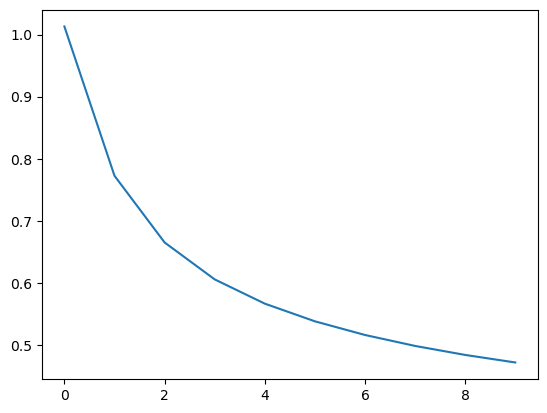

In [244]:
plt.plot(reg_loss)

In [245]:
total_loss1 = 0.
total_loss2 = 0.
total_loss3 = 0.

for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)

        loss1 = torch.sqrt(loss_reg(out[:, 0] * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

        loss2 = torch.sqrt(loss_reg(out[:, 1] * velocity_real[:, 1].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 1].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 1, :, image_size//2]))
        
        loss3 = torch.sqrt(loss_reg(out[:, 2] * velocity_real[:, 2].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 2].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 2, :, image_size//2]))

    total_loss1 += loss1.item()
    total_loss2 += loss2.item()
    total_loss3 += loss3.item()

train_rmse1 = total_loss1 / len(clip_evalloader)
train_rmse2 = total_loss2 / len(clip_evalloader)
train_rmse3 = total_loss3 / len(clip_evalloader)
print("RMSE (Vp): ", train_rmse1)
print("RMSE (Vs): ", train_rmse2)
print("RMSE (Rho): ", train_rmse3)

1500it [00:25, 58.23it/s]

RMSE (Vp):  492.13051424153645
RMSE (Vs):  291.3800614827474
RMSE (Rho):  0.09778401128947735


In [246]:
total_loss1 = 0.
total_loss2 = 0.
total_loss3 = 0.

for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_testloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)

        loss1 = torch.sqrt(loss_reg(out[:, 0] * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

        loss2 = torch.sqrt(loss_reg(out[:, 1] * velocity_real[:, 1].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 1].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 1, :, image_size//2]))
        
        loss3 = torch.sqrt(loss_reg(out[:, 2] * velocity_real[:, 2].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 2].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 2, :, image_size//2]))

    total_loss1 += loss1.item()
    total_loss2 += loss2.item()
    total_loss3 += loss3.item()

train_rmse1 = total_loss1 / len(clip_testloader)
train_rmse2 = total_loss2 / len(clip_testloader)
train_rmse3 = total_loss3 / len(clip_testloader)
print("RMSE (Vp): ", train_rmse1)
print("RMSE (Vs): ", train_rmse2)
print("RMSE (Rho): ", train_rmse3)

375it [00:06, 61.40it/s]

RMSE (Vp):  492.4767783203125
RMSE (Vs):  291.9273310953776
RMSE (Rho):  0.09768684392174085


tensor([ 8144, 38368,  3014, 26678, 46826])


Text(0, 0.5, 'Rho')

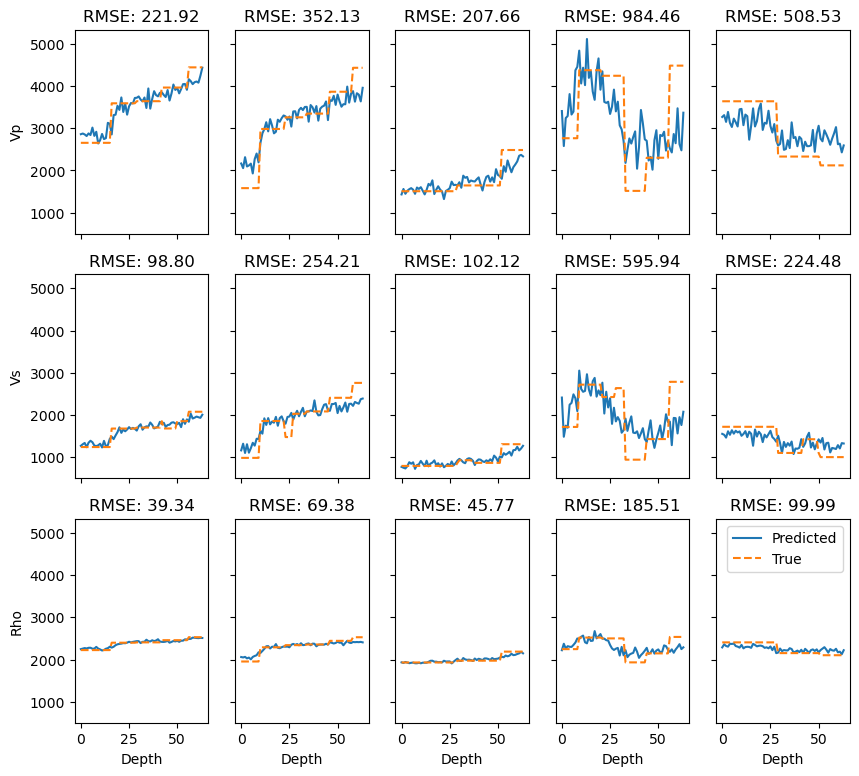

In [260]:
idx = torch.randperm(len(clip_trainset))[:5]
print(idx)

f, ax = plt.subplots(3, 5, sharey=True, sharex=True, figsize=(10, 9))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_trainset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)
        out1 = out[:, 0] * velocity_real[0].std() + velocity_real[0].mean()
        out2 = out[:, 1] * velocity_real[1].std() + velocity_real[1].mean()
        out3 = out[:, 2] * velocity_real[2].std() + velocity_real[2].mean()

        loss1 = torch.sqrt(loss_reg(out1, 
                                   velocity_real[0, :, image_size//2]))
        loss2 = torch.sqrt(loss_reg(out2, 
                                   velocity_real[1, :, image_size//2]))
        loss3 = torch.sqrt(loss_reg(out3, 
                                   velocity_real[2, :, image_size//2]))

    ax[0, i].plot(out1.cpu()[0], label="Predicted")
    ax[0, i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[0, i].set_title("RMSE: {:.2f}".format(loss1.item()))

    ax[1, i].plot(out2.cpu()[0], label="Predicted")
    ax[1, i].plot(velocity_real[1, :, image_size//2].cpu(), '--', label="True")
    ax[1, i].set_title("RMSE: {:.2f}".format(loss2.item()))

    ax[2, i].plot(out3.cpu()[0] * 1000, label="Predicted")
    ax[2, i].plot(velocity_real[2, :, image_size//2].cpu() * 1000, '--', label="True")
    ax[2, i].set_xlabel("Depth")
    ax[2, i].set_title("RMSE: {:.2f}".format(loss3.item()*1000))

plt.legend()
ax[0, 0].set_ylabel("Vp")
ax[1, 0].set_ylabel("Vs")
ax[2, 0].set_ylabel("Rho")

tensor([ 9856, 10867,  8940,  3574,  4452])


Text(0, 0.5, 'Rho')

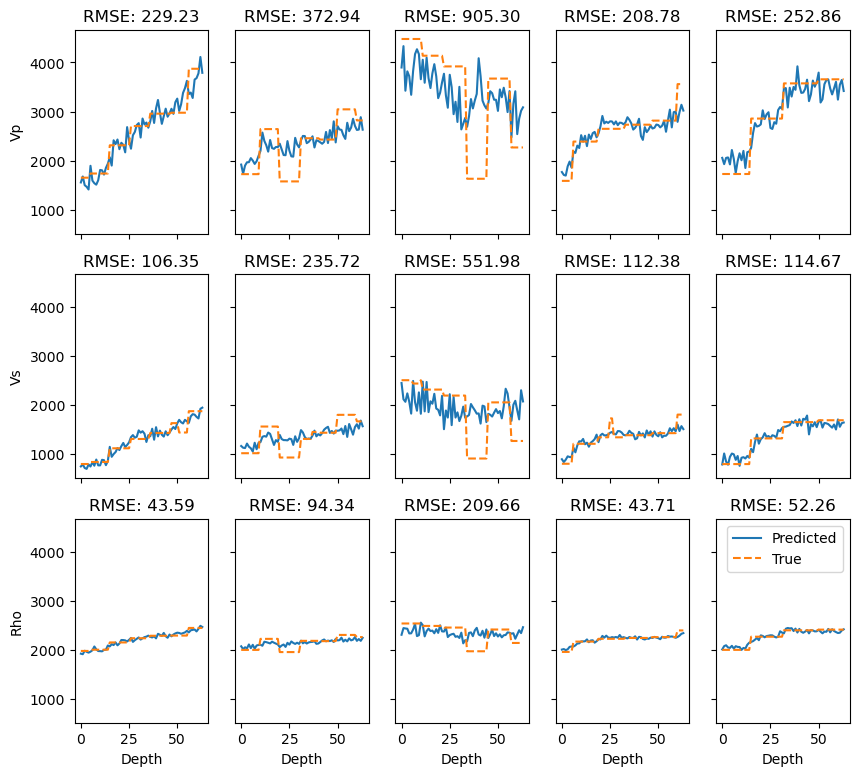

In [261]:
idx = torch.randperm(len(clip_testset))[:5]
print(idx)

f, ax = plt.subplots(3, 5, sharey=True, sharex=True, figsize=(10, 9))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_testset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)
        out1 = out[:, 0] * velocity_real[0].std() + velocity_real[0].mean()
        out2 = out[:, 1] * velocity_real[1].std() + velocity_real[1].mean()
        out3 = out[:, 2] * velocity_real[2].std() + velocity_real[2].mean()

        loss1 = torch.sqrt(loss_reg(out1, 
                                   velocity_real[0, :, image_size//2]))
        loss2 = torch.sqrt(loss_reg(out2, 
                                   velocity_real[1, :, image_size//2]))
        loss3 = torch.sqrt(loss_reg(out3, 
                                   velocity_real[2, :, image_size//2]))

    ax[0, i].plot(out1.cpu()[0], label="Predicted")
    ax[0, i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[0, i].set_title("RMSE: {:.2f}".format(loss1.item()))

    ax[1, i].plot(out2.cpu()[0], label="Predicted")
    ax[1, i].plot(velocity_real[1, :, image_size//2].cpu(), '--', label="True")
    ax[1, i].set_title("RMSE: {:.2f}".format(loss2.item()))

    ax[2, i].plot(out3.cpu()[0] * 1000, label="Predicted")
    ax[2, i].plot(velocity_real[2, :, image_size//2].cpu() * 1000, '--', label="True")
    ax[2, i].set_xlabel("Depth")
    ax[2, i].set_title("RMSE: {:.2f}".format(loss3.item()*1000))

plt.legend()
ax[0, 0].set_ylabel("Vp")
ax[1, 0].set_ylabel("Vs")
ax[2, 0].set_ylabel("Rho")

##### From random (Vp)

In [262]:
regressor = nn.Linear(bert_config.hidden_size, image_size)
regressor.to(device)

reg_loss = []

optimizer_reg = torch.optim.SGD(regressor.parameters(), lr=1e-3)

loss_reg = nn.MSELoss()
reg_losses = []

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    # Use random values
    if epoch == 0:
        features_all = torch.rand(len(clip_trainset), bert_config.hidden_size)
    total_loss = 0.
    for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
        # Forward pass  
        optimizer_reg.zero_grad()
        
        seismic = seismic.to(device)
        velocity = velocity.to(device)

        features = features_all[batch_idx*batch_size:(batch_idx+1)*batch_size]
        features = features.to(device)

        out = regressor(features)

        loss = loss_reg(out, velocity[:, 0, :, image_size//2])

        loss.backward()
        optimizer_reg.step()

        total_loss += loss.item()

    reg_loss.append(total_loss / len(clip_evalloader))

  0%|                                                       | 0/10 [00:00<?, ?it/s]

1500it [00:23, 63.28it/s]
1500it [00:22, 65.72it/s]                           | 1/10 [00:24<03:38, 24.28s/it]
1500it [00:22, 66.62it/s]                           | 2/10 [00:47<03:10, 23.75s/it]
1500it [00:22, 66.03it/s]                           | 3/10 [01:10<02:43, 23.42s/it]
1500it [00:21, 68.37it/s]                           | 4/10 [01:33<02:20, 23.33s/it]
1500it [00:22, 66.23it/s]███▌                       | 5/10 [01:56<01:55, 23.01s/it]
1500it [00:22, 67.90it/s]████████▏                  | 6/10 [02:19<01:32, 23.06s/it]
1500it [00:21, 68.40it/s]████████████▉              | 7/10 [02:42<01:08, 22.91s/it]
1500it [00:23, 65.08it/s]█████████████████▌         | 8/10 [03:04<00:45, 22.77s/it]
1500it [00:22, 68.08it/s]██████████████████████▎    | 9/10 [03:28<00:23, 23.02s/it]
100%|██████████████████████████████████████████████| 10/10 [03:50<00:00, 23.07s/it]


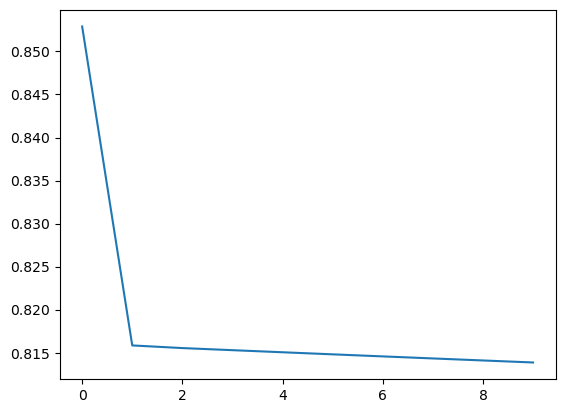

In [263]:
plt.plot(reg_loss)

In [264]:
total_loss = 0.
for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)

        loss = torch.sqrt(loss_reg(out * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

    total_loss += loss.item()

train_rmse = total_loss / len(clip_evalloader)
print("RMSE: ", train_rmse)

1500it [00:24, 62.17it/s]

RMSE:  753.0578325602213


In [265]:
total_loss = 0.
for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_testloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)

        loss = torch.sqrt(loss_reg(out * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

    total_loss += loss.item()

test_rmse = total_loss / len(clip_testloader)
print("RMSE: ", test_rmse)

375it [00:05, 63.12it/s]

RMSE:  751.0425423177084


tensor([43591, 13909, 20178,   368, 29510])


Text(0, 0.5, 'Vp')

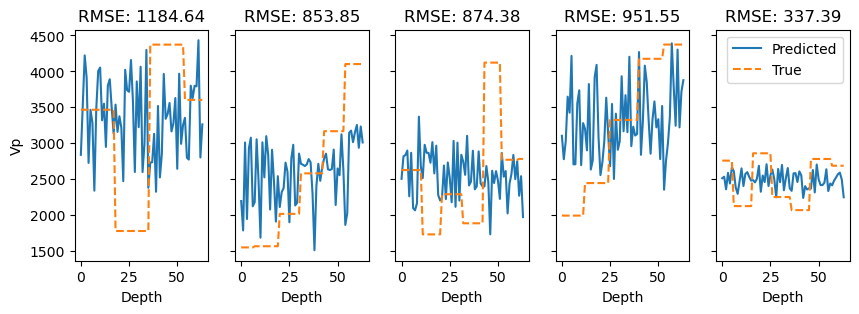

In [266]:
idx = torch.randperm(len(clip_trainset))[:5]
print(idx)

f, ax = plt.subplots(1, 5, sharey=True, figsize=(10, 3))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_trainset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out * velocity_real[0].std() + velocity_real[0].mean()

        loss = torch.sqrt(loss_reg(out, 
                                   velocity_real[0, :, image_size//2]))

    ax[i].plot(out.cpu()[0], label="Predicted")
    ax[i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[i].set_xlabel("Depth")
    ax[i].set_title("RMSE: {:.2f}".format(loss.item()))

plt.legend()
ax[0].set_ylabel("Vp")

tensor([ 1341, 11549,  3463,  9442,  3583])


Text(0, 0.5, 'Vp')

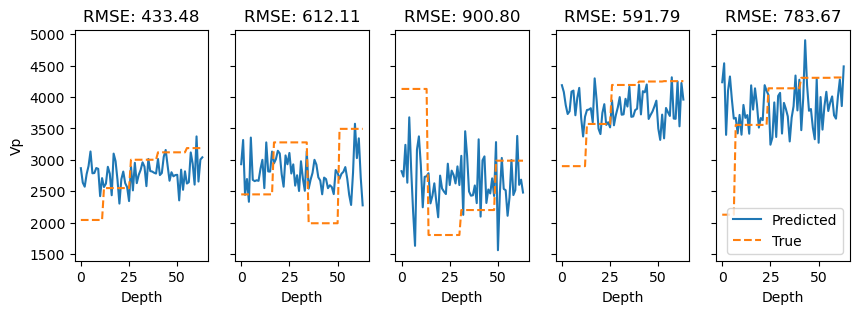

In [267]:
idx = torch.randperm(len(clip_testset))[:5]
print(idx)

f, ax = plt.subplots(1, 5, sharey=True, figsize=(10, 3))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_testset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out * velocity_real[0].std() + velocity_real[0].mean()

        loss = torch.sqrt(loss_reg(out, 
                                   velocity_real[0, :, image_size//2]))

    ax[i].plot(out.cpu()[0], label="Predicted")
    ax[i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[i].set_xlabel("Depth")
    ax[i].set_title("RMSE: {:.2f}".format(loss.item()))

plt.legend()
ax[0].set_ylabel("Vp")

##### From random (Multiparameter)

In [268]:
regressor = nn.Linear(bert_config.hidden_size, 3*image_size)
regressor.to(device)

reg_loss = []

optimizer_reg = torch.optim.SGD(regressor.parameters(), lr=1e-3)

loss_reg = nn.MSELoss()
reg_losses = []

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    # Use random values
    if epoch == 0:
        features_all = torch.rand(len(clip_trainset), bert_config.hidden_size)
    total_loss = 0.
    for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
        # Forward pass  
        optimizer_reg.zero_grad()
        
        seismic = seismic.to(device)
        velocity = velocity.to(device)

        features = features_all[batch_idx*batch_size:(batch_idx+1)*batch_size]
        features = features.to(device)

        out = regressor(features)

        loss = loss_reg(out.view(out.shape[0], 3, -1), velocity[:, :, :, image_size//2])

        loss.backward()
        optimizer_reg.step()

        total_loss += loss.item()

    reg_loss.append(total_loss / len(clip_evalloader))

1500it [00:22, 66.30it/s]                                   | 0/10 [00:00<?, ?it/s]
1500it [00:22, 67.35it/s]                           | 1/10 [00:23<03:28, 23.17s/it]
1500it [00:22, 67.47it/s]                           | 2/10 [00:46<03:04, 23.00s/it]
1500it [00:22, 67.69it/s]                           | 3/10 [01:08<02:40, 22.88s/it]
1500it [00:23, 65.18it/s]                           | 4/10 [01:31<02:16, 22.78s/it]
1500it [00:21, 68.19it/s]███▌                       | 5/10 [01:54<01:55, 23.07s/it]
1500it [00:22, 67.92it/s]████████▏                  | 6/10 [02:17<01:31, 22.87s/it]
1500it [00:22, 66.83it/s]████████████▉              | 7/10 [02:40<01:08, 22.78s/it]
1500it [00:22, 68.09it/s]█████████████████▌         | 8/10 [03:03<00:45, 22.83s/it]
1500it [00:21, 68.41it/s]██████████████████████▎    | 9/10 [03:25<00:22, 22.74s/it]
100%|██████████████████████████████████████████████| 10/10 [03:47<00:00, 22.80s/it]


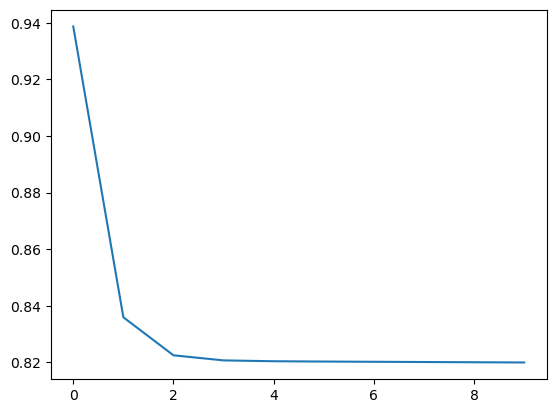

In [269]:
plt.plot(reg_loss)

In [270]:
total_loss1 = 0.
total_loss2 = 0.
total_loss3 = 0.

for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_evalloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)

        loss1 = torch.sqrt(loss_reg(out[:, 0] * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

        loss2 = torch.sqrt(loss_reg(out[:, 1] * velocity_real[:, 1].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 1].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 1, :, image_size//2]))
        
        loss3 = torch.sqrt(loss_reg(out[:, 2] * velocity_real[:, 2].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 2].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 2, :, image_size//2]))

    total_loss1 += loss1.item()
    total_loss2 += loss2.item()
    total_loss3 += loss3.item()

train_rmse1 = total_loss1 / len(clip_evalloader)
train_rmse2 = total_loss2 / len(clip_evalloader)
train_rmse3 = total_loss3 / len(clip_evalloader)
print("RMSE (Vp): ", train_rmse1)
print("RMSE (Vs): ", train_rmse2)
print("RMSE (Rho): ", train_rmse3)

1500it [00:22, 66.83it/s]

RMSE (Vp):  769.7076940104166
RMSE (Vs):  444.0339736328125
RMSE (Rho):  0.1564110655536254


In [271]:
total_loss1 = 0.
total_loss2 = 0.
total_loss3 = 0.

for batch_idx, (seismic, velocity, label, velocity_real) in tqdm(enumerate(clip_testloader)):
    seismic = seismic.to(device)
    velocity = velocity.to(device)
    velocity_real = velocity_real.to(device)

    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic)
        features = features.hidden_states[-1].mean(dim=1)

        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)

        loss1 = torch.sqrt(loss_reg(out[:, 0] * velocity_real[:, 0].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 0].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 0, :, image_size//2]))

        loss2 = torch.sqrt(loss_reg(out[:, 1] * velocity_real[:, 1].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 1].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 1, :, image_size//2]))
        
        loss3 = torch.sqrt(loss_reg(out[:, 2] * velocity_real[:, 2].std(dim=(-1, -2)).unsqueeze(-1) + \
                                   velocity_real[:, 2].mean(dim=(-1, -2)).unsqueeze(-1), 
                                   velocity_real[:, 2, :, image_size//2]))

    total_loss1 += loss1.item()
    total_loss2 += loss2.item()
    total_loss3 += loss3.item()

train_rmse1 = total_loss1 / len(clip_testloader)
train_rmse2 = total_loss2 / len(clip_testloader)
train_rmse3 = total_loss3 / len(clip_testloader)
print("RMSE (Vp): ", train_rmse1)
print("RMSE (Vs): ", train_rmse2)
print("RMSE (Rho): ", train_rmse3)

375it [00:05, 64.03it/s]

RMSE (Vp):  766.4295052083334
RMSE (Vs):  442.2609042154948
RMSE (Rho):  0.15565034023920696


tensor([43730, 47315, 13588, 44605, 25864])


Text(0, 0.5, 'Rho')

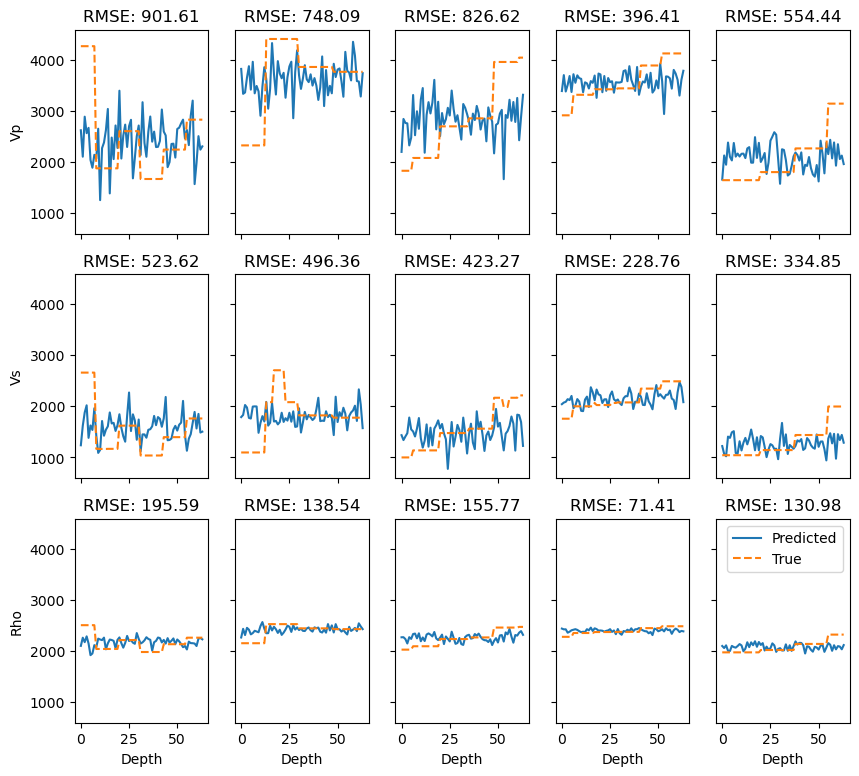

In [272]:
idx = torch.randperm(len(clip_trainset))[:5]
print(idx)

f, ax = plt.subplots(3, 5, sharey=True, sharex=True, figsize=(10, 9))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_trainset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)
        out1 = out[:, 0] * velocity_real[0].std() + velocity_real[0].mean()
        out2 = out[:, 1] * velocity_real[1].std() + velocity_real[1].mean()
        out3 = out[:, 2] * velocity_real[2].std() + velocity_real[2].mean()

        loss1 = torch.sqrt(loss_reg(out1, 
                                   velocity_real[0, :, image_size//2]))
        loss2 = torch.sqrt(loss_reg(out2, 
                                   velocity_real[1, :, image_size//2]))
        loss3 = torch.sqrt(loss_reg(out3, 
                                   velocity_real[2, :, image_size//2]))

    ax[0, i].plot(out1.cpu()[0], label="Predicted")
    ax[0, i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[0, i].set_title("RMSE: {:.2f}".format(loss1.item()))

    ax[1, i].plot(out2.cpu()[0], label="Predicted")
    ax[1, i].plot(velocity_real[1, :, image_size//2].cpu(), '--', label="True")
    ax[1, i].set_title("RMSE: {:.2f}".format(loss2.item()))

    ax[2, i].plot(out3.cpu()[0] * 1000, label="Predicted")
    ax[2, i].plot(velocity_real[2, :, image_size//2].cpu() * 1000, '--', label="True")
    ax[2, i].set_xlabel("Depth")
    ax[2, i].set_title("RMSE: {:.2f}".format(loss3.item()*1000))

plt.legend()
ax[0, 0].set_ylabel("Vp")
ax[1, 0].set_ylabel("Vs")
ax[2, 0].set_ylabel("Rho")

tensor([10096,  1033,  6436, 10091,  4757])


Text(0, 0.5, 'Rho')

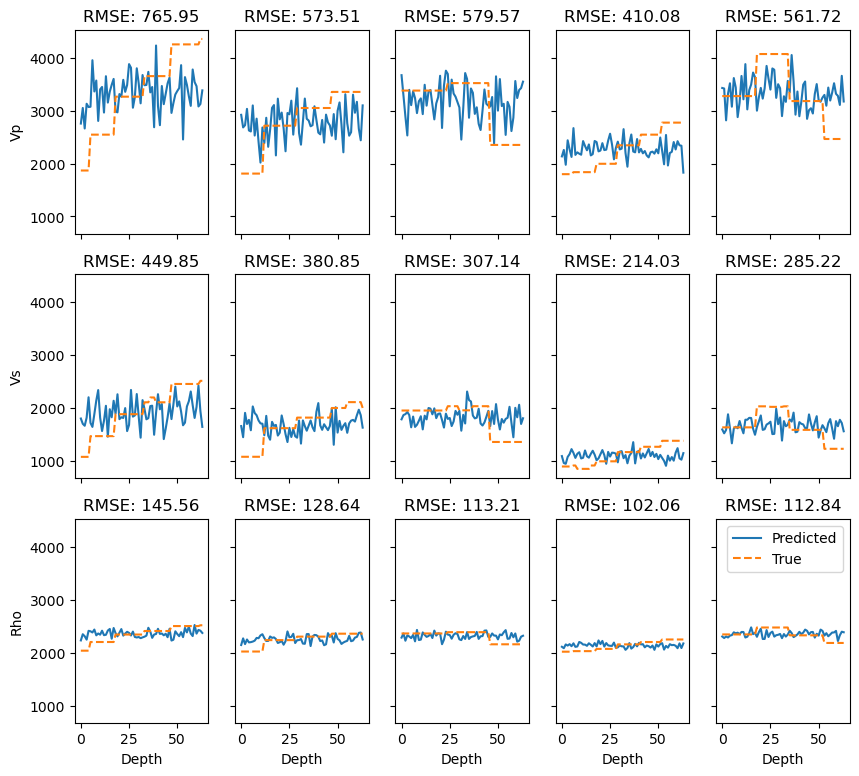

In [273]:
idx = torch.randperm(len(clip_testset))[:5]
print(idx)

f, ax = plt.subplots(3, 5, sharey=True, sharex=True, figsize=(10, 9))
for i in range(5):
    seismic, velocity, label, velocity_real = clip_testset[idx[i]]
    seismic = seismic.to(device)
    velocity_real = velocity_real.to(device)
    with torch.no_grad():
        features = bert_model(inputs_embeds=seismic.unsqueeze(0))
        features = features.hidden_states[-1].mean(dim=1)
        out = regressor(features)
        out = out.view(out.shape[0], 3, -1)
        out1 = out[:, 0] * velocity_real[0].std() + velocity_real[0].mean()
        out2 = out[:, 1] * velocity_real[1].std() + velocity_real[1].mean()
        out3 = out[:, 2] * velocity_real[2].std() + velocity_real[2].mean()

        loss1 = torch.sqrt(loss_reg(out1, 
                                   velocity_real[0, :, image_size//2]))
        loss2 = torch.sqrt(loss_reg(out2, 
                                   velocity_real[1, :, image_size//2]))
        loss3 = torch.sqrt(loss_reg(out3, 
                                   velocity_real[2, :, image_size//2]))

    ax[0, i].plot(out1.cpu()[0], label="Predicted")
    ax[0, i].plot(velocity_real[0, :, image_size//2].cpu(), '--', label="True")
    ax[0, i].set_title("RMSE: {:.2f}".format(loss1.item()))

    ax[1, i].plot(out2.cpu()[0], label="Predicted")
    ax[1, i].plot(velocity_real[1, :, image_size//2].cpu(), '--', label="True")
    ax[1, i].set_title("RMSE: {:.2f}".format(loss2.item()))

    ax[2, i].plot(out3.cpu()[0] * 1000, label="Predicted")
    ax[2, i].plot(velocity_real[2, :, image_size//2].cpu() * 1000, '--', label="True")
    ax[2, i].set_xlabel("Depth")
    ax[2, i].set_title("RMSE: {:.2f}".format(loss3.item()*1000))

plt.legend()
ax[0, 0].set_ylabel("Vp")
ax[1, 0].set_ylabel("Vs")
ax[2, 0].set_ylabel("Rho")